In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, glob, re
import numpy as np
import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture



In [14]:
df_ie_master = pd.read_excel('/opt/experiments/pep_hla_dynamics/data_compiled/df_ie_master_vdw.xlsx')

In [15]:

df_ie_master = df_ie_master[df_ie_master['subtype'].str.startswith(('HLA_A', 'HLA_B'))].copy()

df_ie_master['sample_id'] = df_ie_master['peptide'] + '__' + df_ie_master['subtype']

print("Number of sample :", df_ie_master['sample_id'].nunique())
df_ie_master.head(3)


Number of sample : 1998


Unnamed: 0        IE  res1_index  res2_index res1_chid res2_chid  \
0           0 -1.914090         376         377         C         C   
1           1 -0.140101          65         377         A         C   
2           2 -0.299177          72         379         A         C   

   res1_resnum  res2_resnum      subtype    peptide               sample_id  
0            4            5  HLA_A_68_02  FVANFSMEL  FVANFSMEL__HLA_A_68_02  
1           66            5  HLA_A_68_02  FVANFSMEL  FVANFSMEL__HLA_A_68_02  
2           73            7  HLA_A_68_02  FVANFSMEL  FVANFSMEL__HLA_A_68_02

In [16]:
models_root = "/opt/experiments/pep_hla_dynamics/models"
best_models = []

sample_ids = df_ie_master['sample_id'].unique()

for sample_id in sample_ids:
    try:
        peptide, subtype = sample_id.split("__")

        # HLA-A and version (e.g., HLA-A02.01) klasör ismi
        major, a1, a2, a3 = subtype.split("_")  # HLA, A, 02, 01
        hla_class = f"{major}-{a1}"             # HLA-A
        hla_version = f"{major}-{a1}{a2}.{a3}"   # HLA-A02.01

        # klasör ismi: HLA_A_02_01_<PEPTIDE>
        model_foldername = f"{subtype}_{peptide}"

        # Full yol: /models/HLA-A/HLA-A02.01/HLA_A_02_01_<PEPTIDE>/molpdf_DOPE.tsv
        folder = os.path.join(models_root, hla_class, hla_version, model_foldername)
        tsv_path = os.path.join(folder, "molpdf_DOPE.tsv")

        if not os.path.exists(tsv_path):
            print(f"⛔ Dosya yok: {tsv_path}")
            continue

        df_scores = pd.read_csv(tsv_path, sep="\t", header=None)
        df_scores.columns = ["model", "molpdf", "DOPE"]

        best_row = df_scores.loc[df_scores['DOPE'].idxmin()]
        best_model_path = os.path.join(folder, best_row['model'])

        best_models.append({
            "sample_id": sample_id,
            "peptide": peptide,
            "subtype": subtype,
            "best_model_path": best_model_path,
            "DOPE": best_row["DOPE"]
        })

    except Exception as e:
        print(f"❌ Hata: {sample_id} | {e}")


In [17]:
# Listeyi DataFrame'e çevir
df_best_models = pd.DataFrame(best_models)

# CSV olarak kaydet
df_best_models.to_csv("best_models.csv", index=False)

# Kontrol için ilk 5 satır
df_best_models.head()


sample_id    peptide      subtype  \
0  FVANFSMEL__HLA_A_68_02  FVANFSMEL  HLA_A_68_02   
1  DTAWDFGSI__HLA_A_68_02  DTAWDFGSI  HLA_A_68_02   
2  MIFISSFLL__HLA_A_68_02  MIFISSFLL  HLA_A_68_02   
3  QIFEVYWYL__HLA_A_68_02  QIFEVYWYL  HLA_A_68_02   
4  ELMMTTIGV__HLA_A_68_02  ELMMTTIGV  HLA_A_68_02   

                                     best_model_path        DOPE  
0  /opt/experiments/pep_hla_dynamics/models/HLA-A... -2121.17456  
1  /opt/experiments/pep_hla_dynamics/models/HLA-A... -1648.05383  
2  /opt/experiments/pep_hla_dynamics/models/HLA-A... -2373.50928  
3  /opt/experiments/pep_hla_dynamics/models/HLA-A... -2591.27271  
4  /opt/experiments/pep_hla_dynamics/models/HLA-A... -1794.01794

In [18]:
print(df_best_models)

                   sample_id    peptide      subtype  \
0     FVANFSMEL__HLA_A_68_02  FVANFSMEL  HLA_A_68_02   
1     DTAWDFGSI__HLA_A_68_02  DTAWDFGSI  HLA_A_68_02   
2     MIFISSFLL__HLA_A_68_02  MIFISSFLL  HLA_A_68_02   
3     QIFEVYWYL__HLA_A_68_02  QIFEVYWYL  HLA_A_68_02   
4     ELMMTTIGV__HLA_A_68_02  ELMMTTIGV  HLA_A_68_02   
...                      ...        ...          ...   
1993  HSNLNDATY__HLA_B_35_01  HSNLNDATY  HLA_B_35_01   
1994  FASASSYAI__HLA_B_35_01  FASASSYAI  HLA_B_35_01   
1995  FAHDDRYLY__HLA_B_35_01  FAHDDRYLY  HLA_B_35_01   
1996  MPALTIACM__HLA_B_35_01  MPALTIACM  HLA_B_35_01   
1997  FPYTGDPPY__HLA_B_35_01  FPYTGDPPY  HLA_B_35_01   

                                        best_model_path        DOPE  
0     /opt/experiments/pep_hla_dynamics/models/HLA-A... -2121.17456  
1     /opt/experiments/pep_hla_dynamics/models/HLA-A... -1648.05383  
2     /opt/experiments/pep_hla_dynamics/models/HLA-A... -2373.50928  
3     /opt/experiments/pep_hla_dynamics/models/

In [19]:
features = []

# Her sample için
for sample_id, group in df_ie_master.groupby('sample_id'):
    # Peptit zincirine ait pozisyonları filtrele (2–9 arası)
    mask = (
        ((group['res1_chid'] == 'C') & group['res1_resnum'].between(2, 9)) |
        ((group['res2_chid'] == 'C') & group['res2_resnum'].between(2, 9))
    )
    subset = group[mask]

    features.append({
        'sample_id': sample_id,
        'IE_sum_2_9': subset['IE'].sum(),
        'IE_mean_2_9': subset['IE'].mean(),
        'IE_count_2_9': len(subset),
        'IE_abs_sum_2_9': subset['IE'].abs().sum(),
        'IE_min_2_9': subset['IE'].min(),
        'IE_max_2_9': subset['IE'].max(),
    })

# DataFrame'e çevir
df_features = pd.DataFrame(features)

# İlk 5 örnek
df_features.head()


sample_id  IE_sum_2_9  IE_mean_2_9  IE_count_2_9  \
0  AAAWYLWEV__HLA_A_02_01  -75.865251    -0.335687           226   
1  AAFQSSMTK__HLA_A_11_01  -54.831513    -0.234323           234   
2  AALDGTFQR__HLA_A_11_01  -60.308721    -0.250244           241   
3  AALFMYYAK__HLA_A_11_01  -36.373651    -0.142642           255   
4  AAVEDEEFW__HLA_B_53_01  -53.797225    -0.235953           228   

   IE_abs_sum_2_9  IE_min_2_9  IE_max_2_9  
0      102.011495   -5.142394    2.338886  
1       96.126120   -3.080738    6.919413  
2      103.004498   -3.928107    4.121162  
3      131.418640   -5.676702    7.916134  
4      108.646147   -4.651737    4.681377

In [20]:

# Sample ID dışındaki sayısal sütunlar
numeric_cols = df_features.columns.drop('sample_id')

# Scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features[numeric_cols])

# Scaled DataFrame
df_features_scaled = pd.DataFrame(X_scaled, columns=[col + "_scaled" for col in numeric_cols])
df_features_scaled['sample_id'] = df_features['sample_id'].values

# Gözlemle
df_features_scaled.head()


IE_sum_2_9_scaled  IE_mean_2_9_scaled  IE_count_2_9_scaled  \
0          -0.962656           -1.094983            -0.720519   
1           0.581415            0.582344             0.019586   
2           0.179338            0.318892             0.667178   
3           1.936393            2.099437             1.962361   
4           0.657342            0.555371            -0.535492   

   IE_abs_sum_2_9_scaled  IE_min_2_9_scaled  IE_max_2_9_scaled  \
0              -0.072608          -2.036907          -1.673959   
1              -0.573956           0.943782           1.195293   
2               0.011982          -0.281322          -0.557537   
3               2.432454          -2.809396           1.819642   
4               0.492568          -1.327527          -0.206617   

                sample_id  
0  AAAWYLWEV__HLA_A_02_01  
1  AAFQSSMTK__HLA_A_11_01  
2  AALDGTFQR__HLA_A_11_01  
3  AALFMYYAK__HLA_A_11_01  
4  AAVEDEEFW__HLA_B_53_01

In [21]:
# sample_id üzerinden birleştir
df_merged = pd.merge(df_features_scaled, df_best_models, on="sample_id")

# Gözlemle
print(f"Toplam birleşmiş örnek: {len(df_merged)}")
df_merged.head()

Toplam birleşmiş örnek: 1998


IE_sum_2_9_scaled  IE_mean_2_9_scaled  IE_count_2_9_scaled  \
0          -0.962656           -1.094983            -0.720519   
1           0.581415            0.582344             0.019586   
2           0.179338            0.318892             0.667178   
3           1.936393            2.099437             1.962361   
4           0.657342            0.555371            -0.535492   

   IE_abs_sum_2_9_scaled  IE_min_2_9_scaled  IE_max_2_9_scaled  \
0              -0.072608          -2.036907          -1.673959   
1              -0.573956           0.943782           1.195293   
2               0.011982          -0.281322          -0.557537   
3               2.432454          -2.809396           1.819642   
4               0.492568          -1.327527          -0.206617   

                sample_id    peptide      subtype  \
0  AAAWYLWEV__HLA_A_02_01  AAAWYLWEV  HLA_A_02_01   
1  AAFQSSMTK__HLA_A_11_01  AAFQSSMTK  HLA_A_11_01   
2  AALDGTFQR__HLA_A_11_01  AALDGTFQR  HLA_A_11_01   
3  AALFMYYAK__HLA_A_11_01  AALFMYYAK  HLA_A_11_01   
4  AAVEDEEFW__HLA_B_53_01  AAVEDEEFW  HLA_B_53_01   

                                     best_model_path        DOPE  
0  /opt/experiments/pep_hla_dynamics/models/HLA-A... -2012.79810  
1  /opt/experiments/pep_hla_dynamics/models/HLA-A... -1369.12512  
2  /opt/experiments/pep_hla_dynamics/models/HLA-A... -1497.79187  
3  /opt/experiments/pep_hla_dynamics/models/HLA-A... -1684.59119  
4  /opt/experiments/pep_hla_dynamics/models/HLA-B... -1811.59509

In [22]:
df_merged

IE_sum_2_9_scaled  IE_mean_2_9_scaled  IE_count_2_9_scaled  \
0             -0.962656           -1.094983            -0.720519   
1              0.581415            0.582344             0.019586   
2              0.179338            0.318892             0.667178   
3              1.936393            2.099437             1.962361   
4              0.657342            0.555371            -0.535492   
...                 ...                 ...                  ...   
1993           0.557218            0.608412             0.297125   
1994          -1.765341           -1.839840            -0.535492   
1995          -0.315319           -0.301838            -0.072927   
1996           0.140239           -0.095731            -1.183084   
1997          -0.520147           -0.564691            -0.350466   

      IE_abs_sum_2_9_scaled  IE_min_2_9_scaled  IE_max_2_9_scaled  \
0                 -0.072608          -2.036907          -1.673959   
1                 -0.573956           0.943782           1.195293   
2                  0.011982          -0.281322          -0.557537   
3                  2.432454          -2.809396           1.819642   
4                  0.492568          -1.327527          -0.206617   
...                     ...                ...                ...   
1993               0.371059          -0.318925           0.286957   
1994               0.367425          -0.207814          -1.176152   
1995              -0.156042           0.250465          -0.523690   
1996              -0.593979           1.234379           0.430874   
1997               1.164671          -1.548680           1.553218   

                   sample_id    peptide      subtype  \
0     AAAWYLWEV__HLA_A_02_01  AAAWYLWEV  HLA_A_02_01   
1     AAFQSSMTK__HLA_A_11_01  AAFQSSMTK  HLA_A_11_01   
2     AALDGTFQR__HLA_A_11_01  AALDGTFQR  HLA_A_11_01   
3     AALFMYYAK__HLA_A_11_01  AALFMYYAK  HLA_A_11_01   
4     AAVEDEEFW__HLA_B_53_01  AAVEDEEFW  HLA_B_53_01   
...                      ...        ...          ...   
1993  YVLGVFLRK__HLA_A_11_01  YVLGVFLRK  HLA_A_11_01   
1994  YVMTMILFL__HLA_A_02_01  YVMTMILFL  HLA_A_02_01   
1995  YVNAILYQI__HLA_A_68_02  YVNAILYQI  HLA_A_68_02   
1996  YVSSIFLHL__HLA_A_68_02  YVSSIFLHL  HLA_A_68_02   
1997  YVYFYDLSY__HLA_B_35_01  YVYFYDLSY  HLA_B_35_01   

                                        best_model_path        DOPE  
0     /opt/experiments/pep_hla_dynamics/models/HLA-A... -2012.79810  
1     /opt/experiments/pep_hla_dynamics/models/HLA-A... -1369.12512  
2     /opt/experiments/pep_hla_dynamics/models/HLA-A... -1497.79187  
3     /opt/experiments/pep_hla_dynamics/models/HLA-A... -1684.59119  
4     /opt/experiments/pep_hla_dynamics/models/HLA-B... -1811.59509  
...                                                 ...         ...  
1993  /opt/experiments/pep_hla_dynamics/models/HLA-A... -2091.33032  
1994  /opt/experiments/pep_hla_dynamics/models/HLA-A... -2590.51270  
1995  /opt/experiments/pep_hla_dynamics/models/HLA-A... -2244.03589  
1996  /opt/experiments/pep_hla_dynamics/models/HLA-A... -2352.42749  
1997  /opt/experiments/pep_hla_dynamics/models/HLA-B... -2861.39502  

[1998 rows x 11 columns]

In [23]:
# Clustering için kullanılacak özellik sütunları
cluster_features = [
    'IE_sum_2_9_scaled',
    'IE_mean_2_9_scaled',
    'IE_count_2_9_scaled',
    'IE_abs_sum_2_9_scaled',
    'IE_min_2_9_scaled',
    'IE_max_2_9_scaled'
]

X_cluster = df_merged[cluster_features].copy()
X_cluster.head()


IE_sum_2_9_scaled  IE_mean_2_9_scaled  IE_count_2_9_scaled  \
0          -0.962656           -1.094983            -0.720519   
1           0.581415            0.582344             0.019586   
2           0.179338            0.318892             0.667178   
3           1.936393            2.099437             1.962361   
4           0.657342            0.555371            -0.535492   

   IE_abs_sum_2_9_scaled  IE_min_2_9_scaled  IE_max_2_9_scaled  
0              -0.072608          -2.036907          -1.673959  
1              -0.573956           0.943782           1.195293  
2               0.011982          -0.281322          -0.557537  
3               2.432454          -2.809396           1.819642  
4               0.492568          -1.327527          -0.206617

Küme boyutları:
kmeans_cluster
2    897
0    735
1    366
Name: count, dtype: int64
Silhouette Skoru (k=3): 0.202


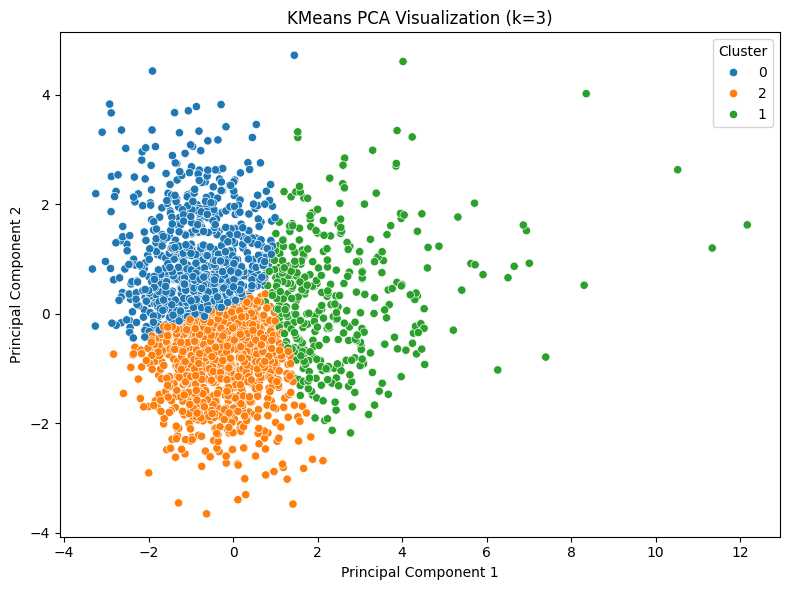

In [36]:
# KMeans clustering
from sklearn.cluster import KMeans

# Kaç küme? (denemelik olarak 3 ile başlayalım)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_merged['kmeans_cluster'] = kmeans.fit_predict(X_cluster)

# Küme boyutları
print("Küme boyutları:")
print(df_merged['kmeans_cluster'].value_counts())

# İlk 5 örnek (küme etiketiyle birlikte)
df_merged.head()

from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_cluster, df_merged['kmeans_cluster'])
print(f"Silhouette Skoru (k={k}): {sil_score:.3f}")

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 2 boyutlu PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

# PCA dataframe
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['cluster'] = df_merged['kmeans_cluster'].astype(str)

# Görselleştir
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='tab10')
plt.title(f"KMeans PCA Visualization (k={k})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


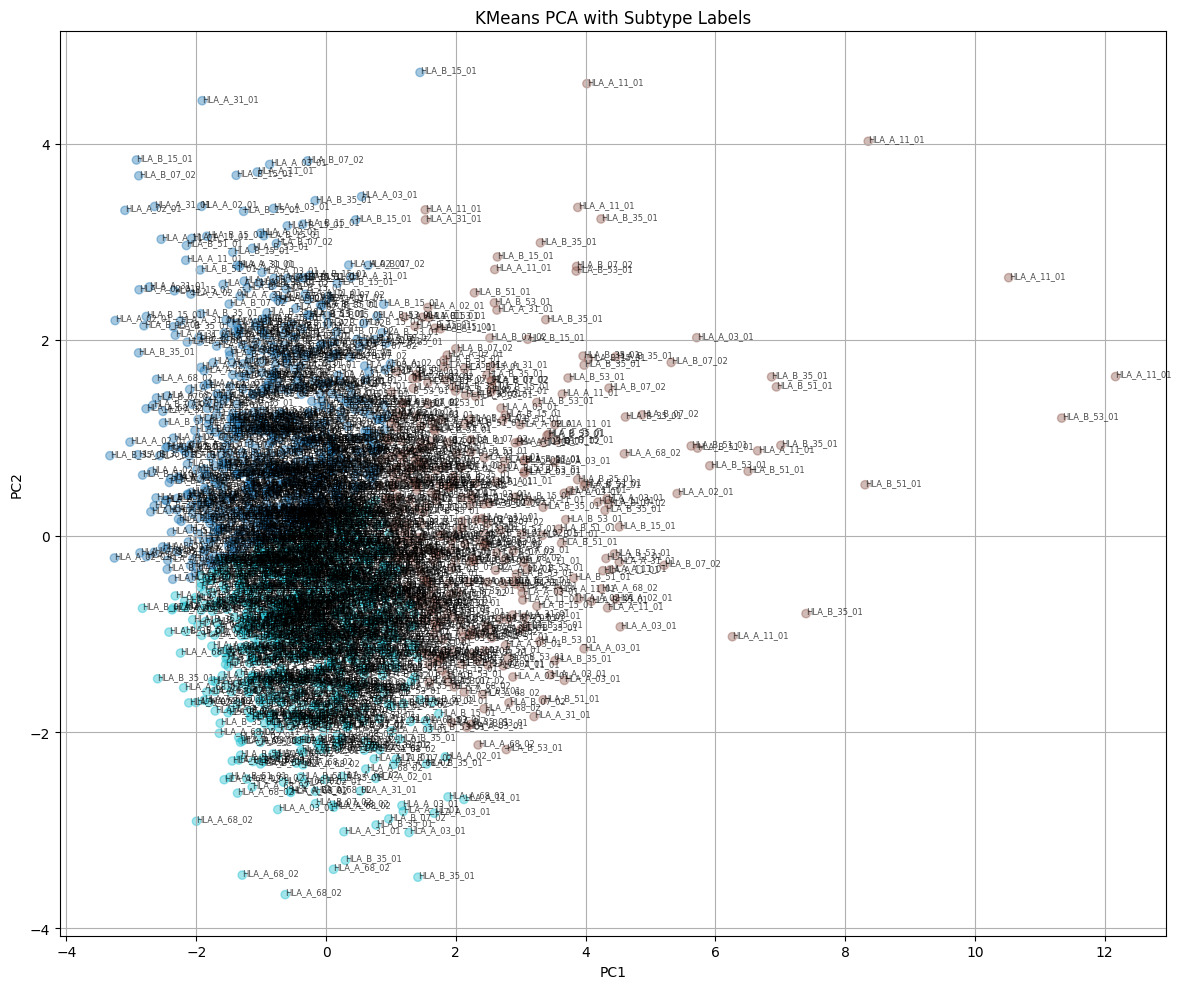

In [41]:
plt.figure(figsize=(12, 10))

# PCA bileşenlerini df_merged içine ekleyerek yeni bir DataFrame hazırla
df_pca_plot = df_merged.copy()
df_pca_plot["PC1"] = X_pca[:, 0]
df_pca_plot["PC2"] = X_pca[:, 1]


for i, row in df_pca_plot.iterrows():
    plt.text(row["PC1"], row["PC2"], row["subtype"], fontsize=6, alpha=0.7)

plt.scatter(df_pca_plot["PC1"], df_pca_plot["PC2"], c=df_pca_plot["kmeans_cluster"], cmap="tab10", alpha=0.4)
plt.title("KMeans PCA with Subtype Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

Silhouette Skoru (k=2): 0.272


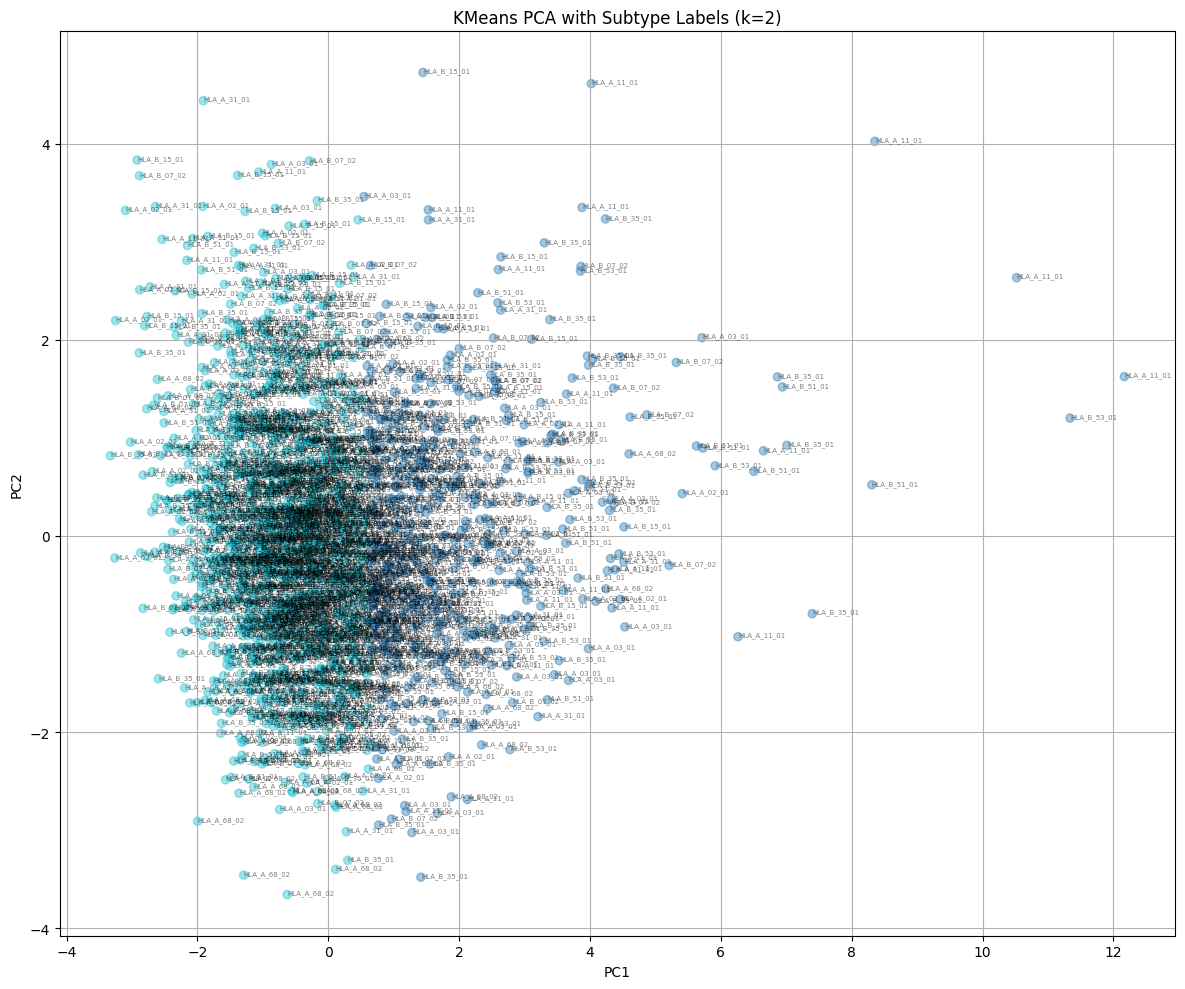

In [42]:
# KMeans clustering (k = 2)
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_merged['kmeans_cluster'] = kmeans.fit_predict(X_cluster)
sil_score = silhouette_score(X_cluster, df_merged['kmeans_cluster'])
print(f"Silhouette Skoru (k={k}): {sil_score:.3f}")
# PCA vektörlerini güncelle
X_pca = PCA(n_components=2).fit_transform(X_cluster)

# Görsel için dataframe
df_pca_plot = df_merged.copy()
df_pca_plot["PC1"] = X_pca[:, 0]
df_pca_plot["PC2"] = X_pca[:, 1]
plt.figure(figsize=(12, 10))

for _, row in df_pca_plot.iterrows():
    plt.text(row["PC1"], row["PC2"], row["subtype"], fontsize=5, alpha=0.5)

plt.scatter(
    df_pca_plot["PC1"],
    df_pca_plot["PC2"],
    c=df_pca_plot["kmeans_cluster"],
    cmap="tab10",
    alpha=0.4
)

plt.title("KMeans PCA with Subtype Labels (k=2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


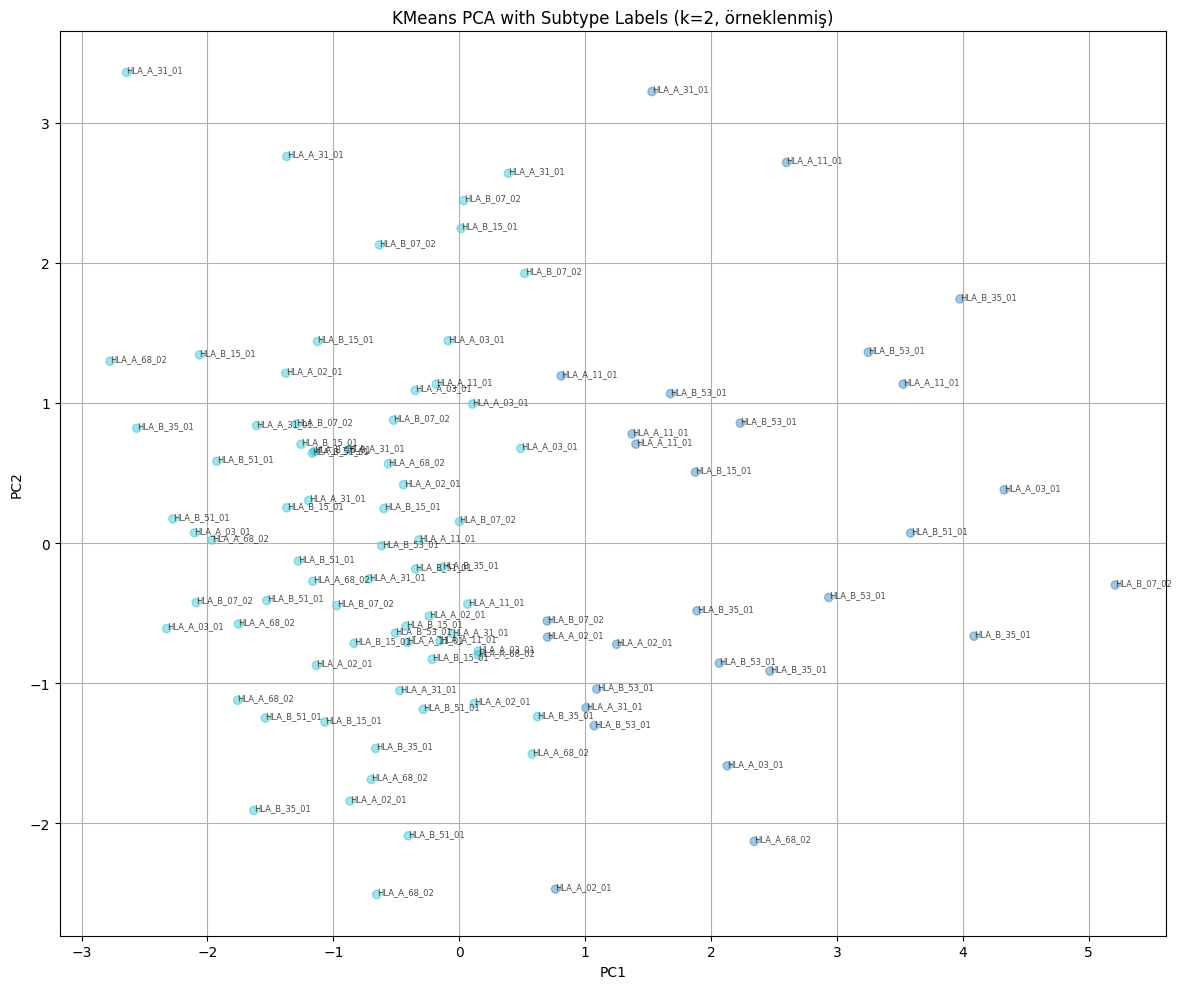

In [44]:
#karışıklığı azaltmak için;
# Rastgele 100 örneği gösterelim
sampled = df_pca_plot.sample(100, random_state=42)

plt.figure(figsize=(12, 10))
for _, row in sampled.iterrows():
    plt.text(row["PC1"], row["PC2"], row["subtype"], fontsize=6, alpha=0.7)

plt.scatter(sampled["PC1"], sampled["PC2"], c=sampled["kmeans_cluster"], cmap="tab10", alpha=0.4)
plt.title("KMeans PCA with Subtype Labels (k=2, örneklenmiş)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
#Her kümeden DOPE'a göre en iyi 5 model:
top_models = []

for cluster_id, group in df_merged.groupby('kmeans_cluster'):
    top = group.sort_values(by='DOPE').head(5).copy()
    top['rank_in_cluster'] = range(1, len(top)+1)
    top_models.append(top)

df_top_models = pd.concat(top_models).reset_index(drop=True)
df_top_models[['sample_id', 'subtype', 'kmeans_cluster', 'DOPE', 'rank_in_cluster']].head(10)


sample_id      subtype  kmeans_cluster        DOPE  \
0  VAFLRFLTI__HLA_B_51_01  HLA_B_51_01               0 -2861.39722   
1  VLFEVFVVF__HLA_B_15_01  HLA_B_15_01               0 -2828.09399   
2  MIAGVFFTF__HLA_B_35_01  HLA_B_35_01               0 -2783.05884   
3  MPYVFTLLF__HLA_B_53_01  HLA_B_53_01               0 -2781.84912   
4  FPFCLAFSY__HLA_B_53_01  HLA_B_53_01               0 -2774.03101   
5  ILFLWSFLV__HLA_A_02_01  HLA_A_02_01               1 -2941.95288   
6  YVYFYDLSY__HLA_B_35_01  HLA_B_35_01               1 -2861.39502   
7  IAFLRFLAI__HLA_B_51_01  HLA_B_51_01               1 -2837.49658   
8  FLNISWFYI__HLA_A_02_01  HLA_A_02_01               1 -2803.69727   
9  MAFIAFLRF__HLA_B_53_01  HLA_B_53_01               1 -2794.80029   

   rank_in_cluster  
0                1  
1                2  
2                3  
3                4  
4                5  
5                1  
6                2  
7                3  
8                4  
9                5

In [46]:
df_merged.to_csv("clustered_pmhc_models_k2.csv", index=False)
df_top_models.to_csv("top5_models_per_cluster_k2.csv", index=False)


Agglomerative Silhouette Skoru (k=2): 0.214


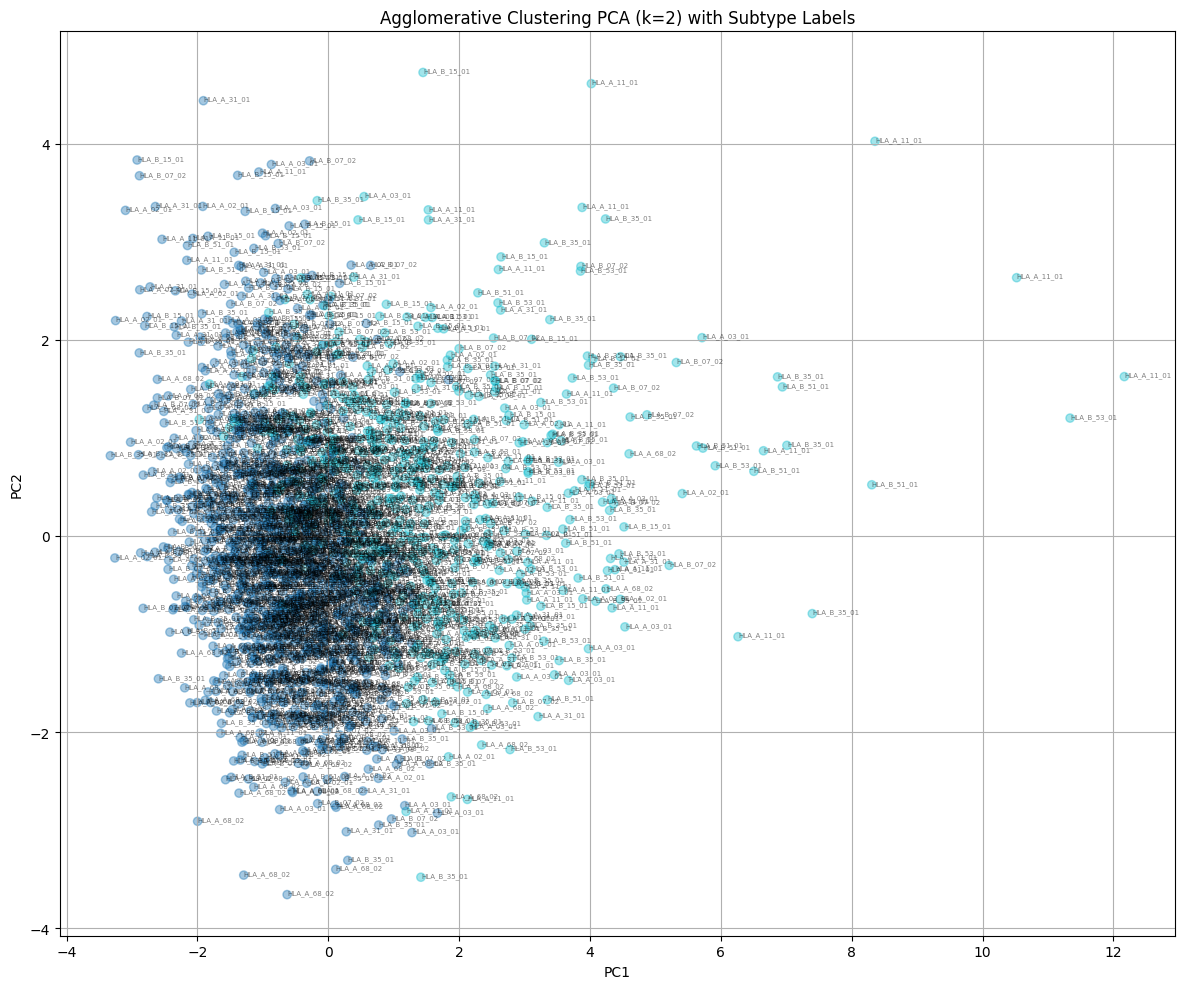

In [49]:
#Agglomerative clustering (örnek: k = 2)
from sklearn.cluster import AgglomerativeClustering

k = 2  # Küme sayısı
agglo = AgglomerativeClustering(n_clusters=k, linkage="ward")  # linkage metodu 'ward' olarak ayarlandı. ward: min varyanslı birleştirir
df_merged['agglo_cluster'] = agglo.fit_predict(X_cluster)

sil_score = silhouette_score(X_cluster, df_merged['agglo_cluster'])
print(f"Agglomerative Silhouette Skoru (k={k}): {sil_score:.3f}")

# PCA zaten yapılmıştı: X_pca
df_pca_plot = df_merged.copy()
df_pca_plot["PC1"] = X_pca[:, 0]
df_pca_plot["PC2"] = X_pca[:, 1]

# Görselleştirme
plt.figure(figsize=(12, 10))

for _, row in df_pca_plot.iterrows():
    plt.text(row["PC1"], row["PC2"], row["subtype"], fontsize=5, alpha=0.5)

plt.scatter(
    df_pca_plot["PC1"],
    df_pca_plot["PC2"],
    c=df_pca_plot["agglo_cluster"],
    cmap="tab10",
    alpha=0.4
)

plt.title("Agglomerative Clustering PCA (k=2) with Subtype Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

top_models_agglo = []

for cluster_id, group in df_merged.groupby('agglo_cluster'):
    top = group.sort_values(by='DOPE').head(5).copy()
    top['rank_in_cluster'] = range(1, len(top)+1)
    top_models_agglo.append(top)

df_top_models_agglo = pd.concat(top_models_agglo).reset_index(drop=True)
df_top_models_agglo[['sample_id', 'subtype', 'agglo_cluster', 'DOPE', 'rank_in_cluster']]

df_merged.to_csv("clustered_pmhc_models_agglo_k2.csv", index=False)
df_top_models_agglo.to_csv("top5_models_per_cluster_agglo_k2.csv", index=False)


Agglomerative Silhouette Skoru (k=3): 0.118


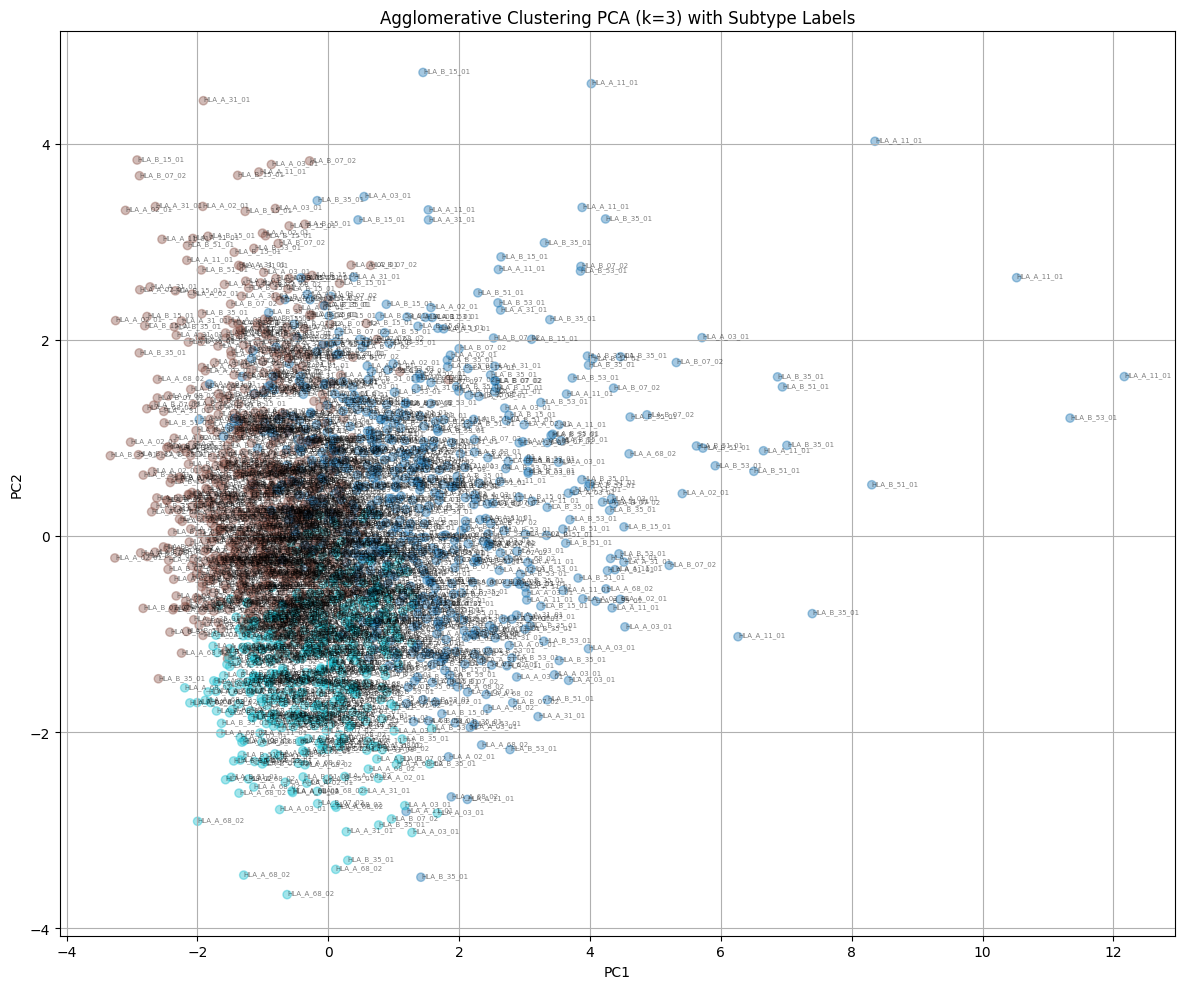

In [54]:
#Agglomerative Clustering (k = 3)
k = 3
agglo = AgglomerativeClustering(n_clusters=k, linkage="ward")
df_merged['agglo_cluster_k3'] = agglo.fit_predict(X_cluster)
sil_score = silhouette_score(X_cluster, df_merged['agglo_cluster_k3'])
print(f"Agglomerative Silhouette Skoru (k=3): {sil_score:.3f}")

df_pca_plot = df_merged.copy()
df_pca_plot["PC1"] = X_pca[:, 0]
df_pca_plot["PC2"] = X_pca[:, 1]

plt.figure(figsize=(12, 10))

for _, row in df_pca_plot.iterrows():
    plt.text(row["PC1"], row["PC2"], row["subtype"], fontsize=5, alpha=0.5)

plt.scatter(
    df_pca_plot["PC1"],
    df_pca_plot["PC2"],
    c=df_pca_plot["agglo_cluster_k3"],
    cmap="tab10",
    alpha=0.4
)

plt.title("Agglomerative Clustering PCA (k=3) with Subtype Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

top_models_agglo_k3 = []

for cluster_id, group in df_merged.groupby('agglo_cluster_k3'):
    top = group.sort_values(by='DOPE').head(5).copy()
    top['rank_in_cluster'] = range(1, len(top)+1)
    top_models_agglo_k3.append(top)

df_top_models_agglo_k3 = pd.concat(top_models_agglo_k3).reset_index(drop=True)
df_top_models_agglo_k3[['sample_id', 'subtype', 'agglo_cluster_k3', 'DOPE', 'rank_in_cluster']]

df_merged.to_csv("clustered_pmhc_models_agglo_k3.csv", index=False)
df_top_models_agglo_k3.to_csv("top5_models_per_cluster_agglo_k3.csv", index=False)


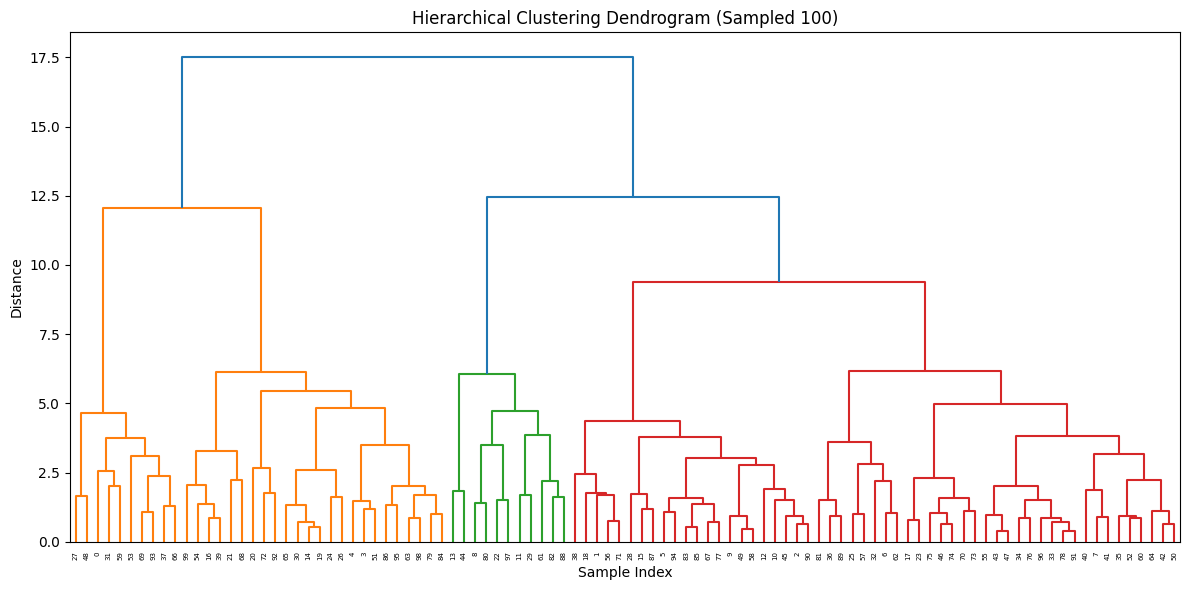

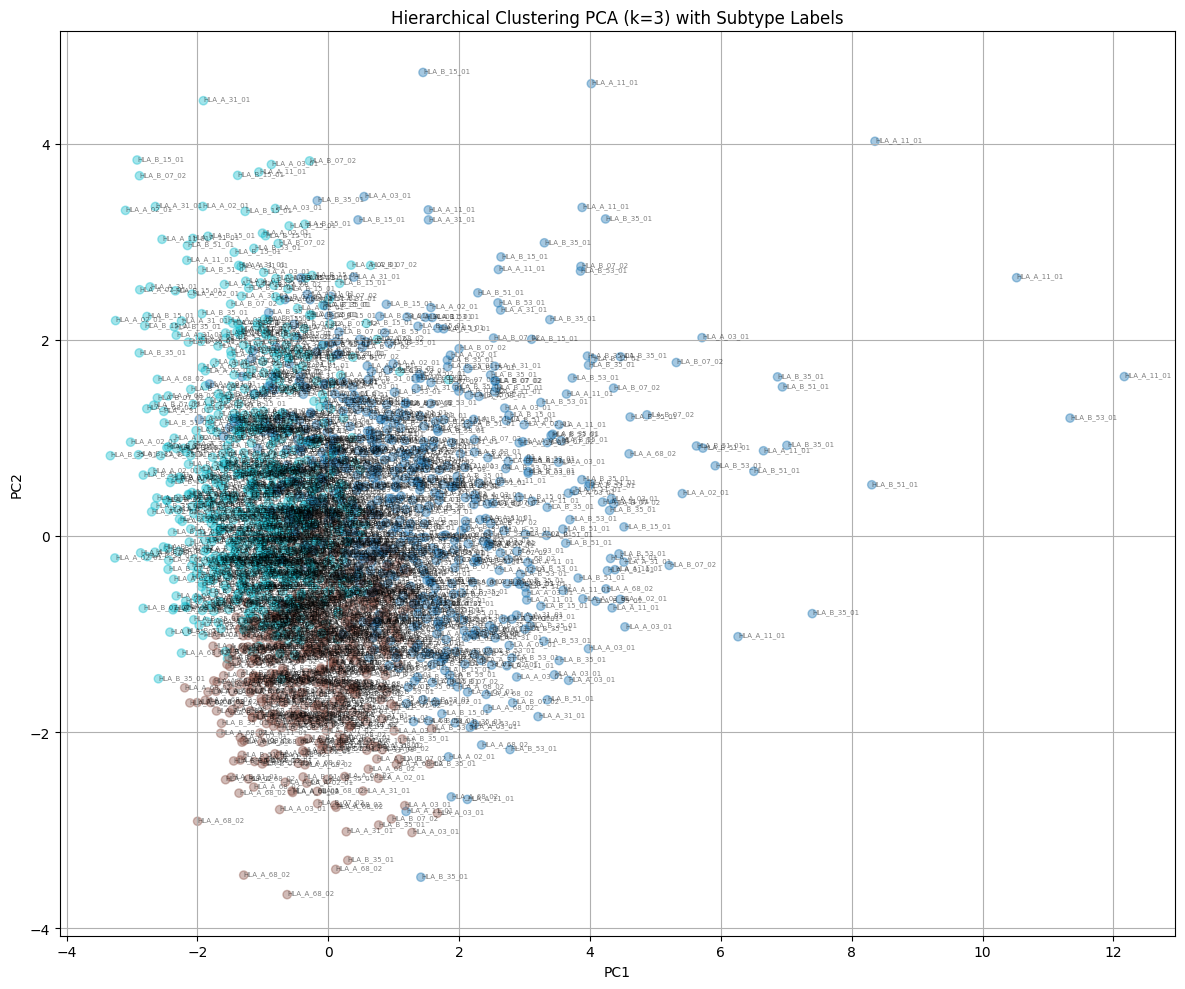

In [58]:
#HİYERARŞİK CLUSTERING + DENDROGRAM (SCIPY)

# 'ward', 'average', 'complete', 'single' gibi seçenekler olabilir
Z = linkage(X_cluster, method='ward')  # UPGMA benzeri, varyansı minimize eder


#Çok sayıda örnek varsa doğrudan çizim karmaşık olabilir, o yüzden önce örnekliyoruz

import matplotlib.pyplot as plt

# Eğer örnek sayısı yüksekse (örneğin > 300), rastgele 100 örnekle çizelim
if X_cluster.shape[0] > 300:
    from sklearn.utils import resample
    
    X_sampled = resample(X_cluster, n_samples=100, random_state=42, replace=False)
    Z_sampled = linkage(X_sampled, method='ward')

    plt.figure(figsize=(12, 6))
    dendrogram(Z_sampled)
    plt.title("Hierarchical Clustering Dendrogram (Sampled 100)")
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()
else:
    # Tüm veriyle çiz
    plt.figure(figsize=(15, 6))
    dendrogram(Z)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()


# Dendrogram’dan k = 3 olacak şekilde kesim yap

k = 3
df_merged['hierarchical_cluster_k3'] = fcluster(Z, k, criterion='maxclust')


#PCA + Subtype görselleştirme
df_pca_plot = df_merged.copy()
df_pca_plot["PC1"] = X_pca[:, 0]
df_pca_plot["PC2"] = X_pca[:, 1]

plt.figure(figsize=(12, 10))

for _, row in df_pca_plot.iterrows():
    plt.text(row["PC1"], row["PC2"], row["subtype"], fontsize=5, alpha=0.5)

plt.scatter(
    df_pca_plot["PC1"],
    df_pca_plot["PC2"],
    c=df_pca_plot["hierarchical_cluster_k3"],
    cmap="tab10",
    alpha=0.4
)

plt.title("Hierarchical Clustering PCA (k=3) with Subtype Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()



# Her kümeden DOPE'a göre en iyi 5 model:
top_models_hier_k3 = []

for cluster_id, group in df_merged.groupby('hierarchical_cluster_k3'):
    top = group.sort_values(by='DOPE').head(5).copy()
    top['rank_in_cluster'] = range(1, len(top)+1)
    top_models_hier_k3.append(top)

df_top_models_hier_k3 = pd.concat(top_models_hier_k3).reset_index(drop=True)
df_top_models_hier_k3[['sample_id', 'subtype', 'hierarchical_cluster_k3', 'DOPE', 'rank_in_cluster']]



df_merged.to_csv("clustered_pmhc_models_hierarchical_k3.csv", index=False)
df_top_models_hier_k3.to_csv("top5_models_per_cluster_hierarchical_k3.csv", index=False)




HLA-A DBSCAN Küme Dağılımı:
dbscan_cluster_A
 0    932
-1     63
 1      5
Name: count, dtype: int64

HLA-B DBSCAN Küme Dağılımı:
dbscan_cluster_B
 0    910
-1     84
 1      4
Name: count, dtype: int64
✅ Silhouette Skoru (HLA-A): 0.434
✅ Silhouette Skoru (HLA-B): 0.196


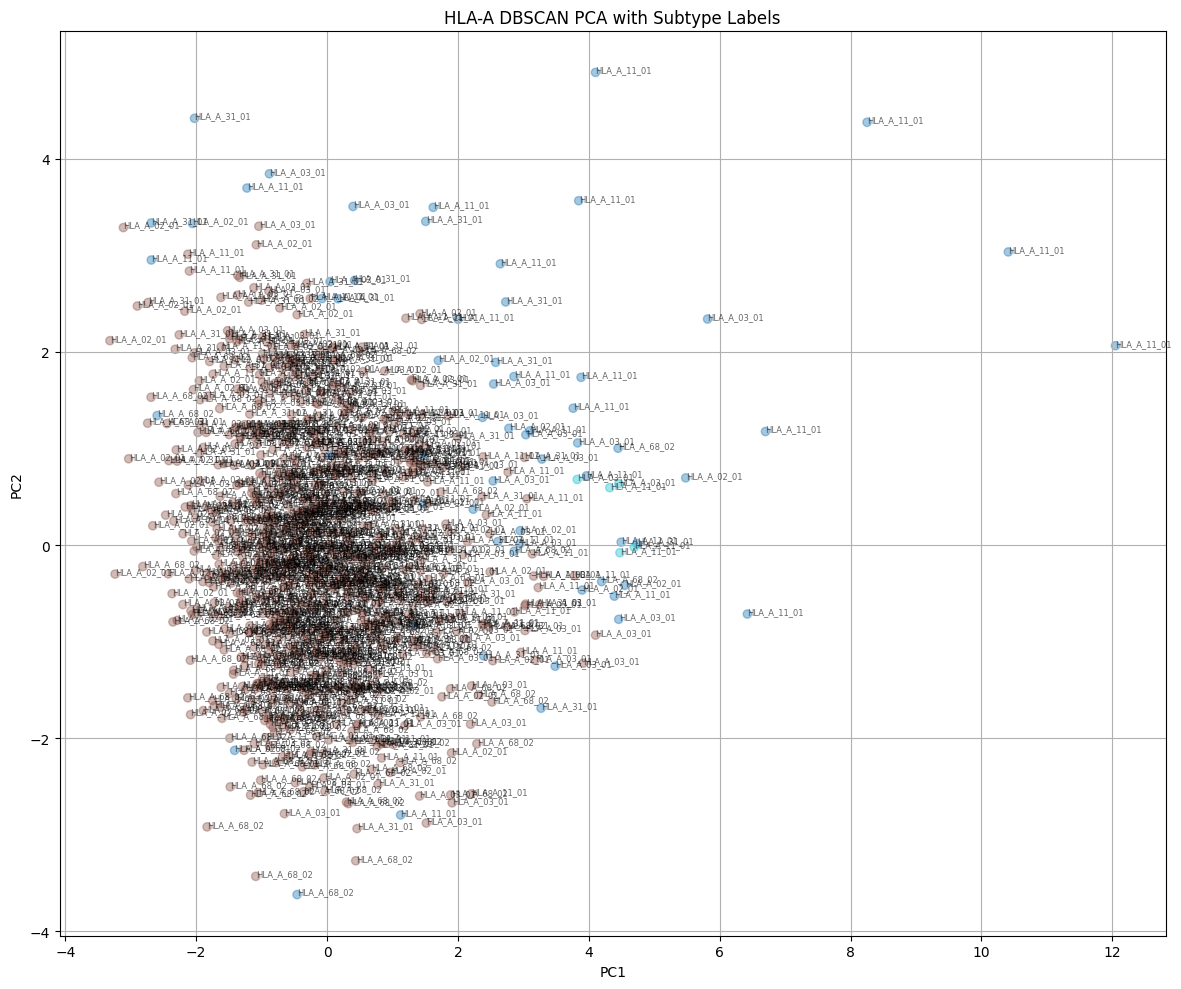

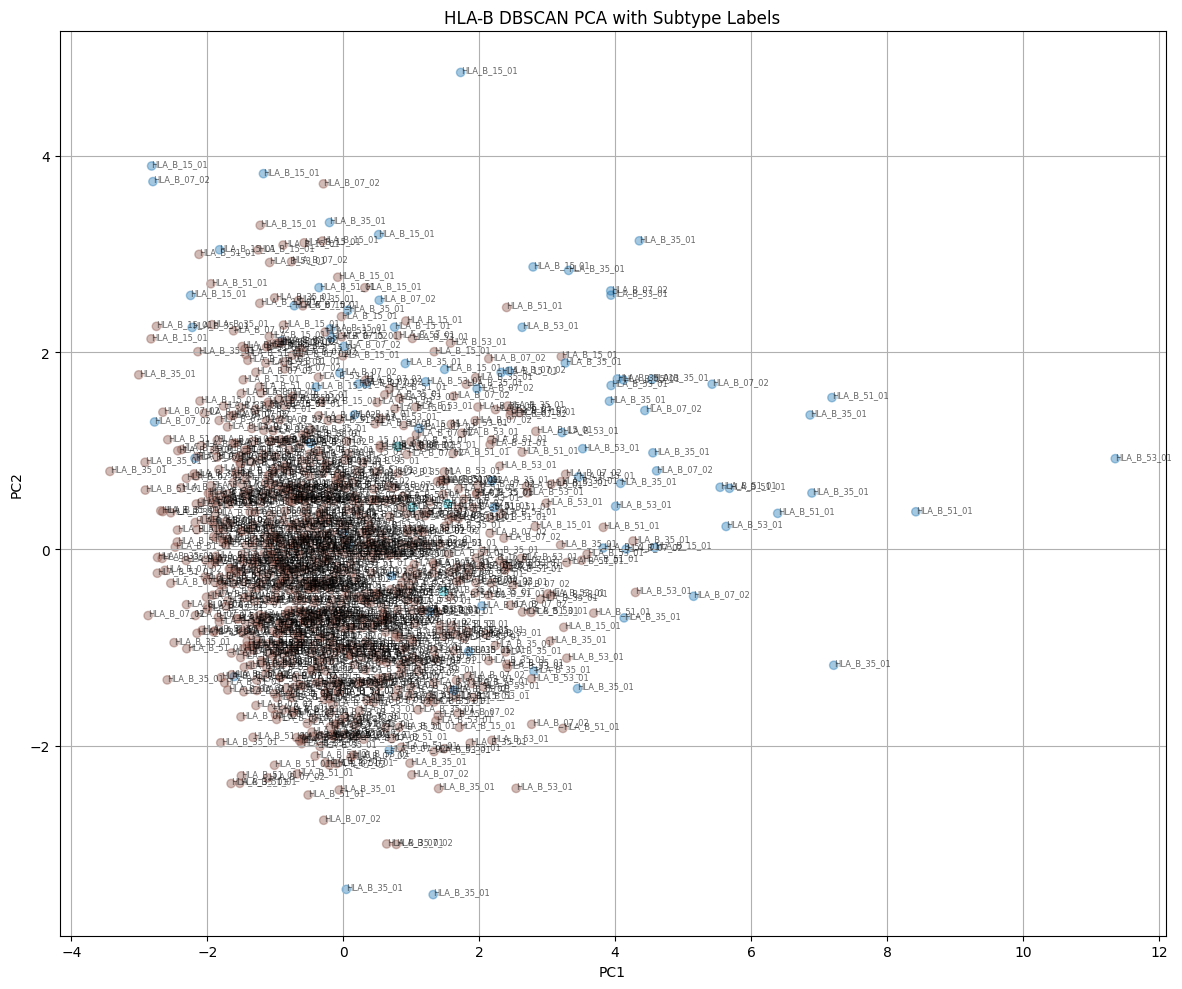

In [72]:
# DBSCAN parametreleri:
df_A = df_merged[df_merged['subtype'].str.startswith('HLA_A')].copy()
df_B = df_merged[df_merged['subtype'].str.startswith('HLA_B')].copy()

X_A = X_cluster.iloc[df_A.index]
X_B = X_cluster.iloc[df_B.index]

# HLA-A DBSCAN
dbscan_A = DBSCAN(eps=1.2, min_samples=5)
df_A['dbscan_cluster_A'] = dbscan_A.fit_predict(X_A)

# HLA-B DBSCAN
dbscan_B = DBSCAN(eps=1.2, min_samples=5)
df_B['dbscan_cluster_B'] = dbscan_B.fit_predict(X_B)


#küme dağılımlarını göster
print("HLA-A DBSCAN Küme Dağılımı:")
print(df_A['dbscan_cluster_A'].value_counts())
print("\nHLA-B DBSCAN Küme Dağılımı:")
print(df_B['dbscan_cluster_B'].value_counts())

#silhouette skorları
from sklearn.metrics import silhouette_score

def safe_silhouette(X, labels, label_name):
    mask = labels != -1
    n_clusters = len(set(labels[mask]))
    if n_clusters >= 2:
        score = silhouette_score(X[mask], labels[mask])
        print(f"✅ Silhouette Skoru ({label_name}): {score:.3f}")
    else:
        print(f"⚠️ {label_name} için yeterli küme oluşmadı (yalnızca {n_clusters} küme var)")

safe_silhouette(X_A, df_A['dbscan_cluster_A'], "HLA-A")
safe_silhouette(X_B, df_B['dbscan_cluster_B'], "HLA-B")


#PCA görselleştirme
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# HLA-A PCA
pca_A = PCA(n_components=2)
X_pca_A = pca_A.fit_transform(X_A)
df_A["PC1"] = X_pca_A[:, 0]
df_A["PC2"] = X_pca_A[:, 1]

plt.figure(figsize=(12, 10))
for i, row in df_A.iterrows():
    plt.text(row["PC1"], row["PC2"], row["subtype"], fontsize=6, alpha=0.6)

plt.scatter(df_A["PC1"], df_A["PC2"], c=df_A["dbscan_cluster_A"], cmap="tab10", alpha=0.4)
plt.title("HLA-A DBSCAN PCA with Subtype Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


# HLA-B PCA
pca_B = PCA(n_components=2)
X_pca_B = pca_B.fit_transform(X_B)
df_B["PC1"] = X_pca_B[:, 0]
df_B["PC2"] = X_pca_B[:, 1]

plt.figure(figsize=(12, 10))
for i, row in df_B.iterrows():
    plt.text(row["PC1"], row["PC2"], row["subtype"], fontsize=6, alpha=0.6)

plt.scatter(df_B["PC1"], df_B["PC2"], c=df_B["dbscan_cluster_B"], cmap="tab10", alpha=0.4)
plt.title("HLA-B DBSCAN PCA with Subtype Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

#Her kümeden DOPE'a göre en iyi 5 model:
top_models_A = []
for cluster_id, group in df_A[df_A['dbscan_cluster_A'] != -1].groupby('dbscan_cluster_A'):
    top = group.sort_values('DOPE').head(5).copy()
    top['rank_in_cluster'] = range(1, len(top)+1)
    top_models_A.append(top)

top_models_B = []
for cluster_id, group in df_B[df_B['dbscan_cluster_B'] != -1].groupby('dbscan_cluster_B'):
    top = group.sort_values('DOPE').head(5).copy()
    top['rank_in_cluster'] = range(1, len(top)+1)
    top_models_B.append(top)

df_top_models_AB = pd.concat(top_models_A + top_models_B).reset_index(drop=True)
df_top_models_AB[['sample_id', 'subtype', 'DOPE', 'rank_in_cluster']]


#dışa aktar
df_top_models_AB.to_csv("top5_models_per_cluster_DBSCAN_A_B.csv", index=False)




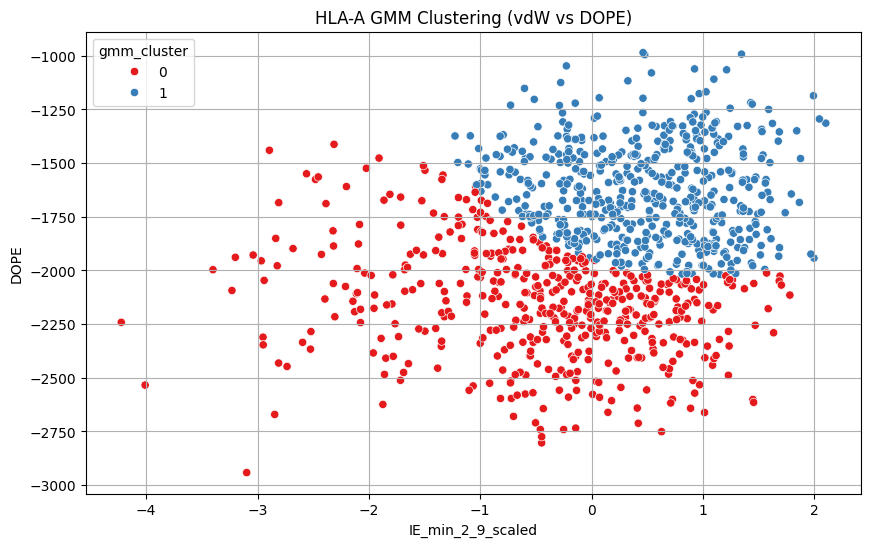

🔹 best_models_HLA_A_GMM.csv ve best_models_HLA_B_GMM.csv dosyaları kaydedildi.


In [82]:
# Gaussian Mixture Model (GMM) clustering
features = ['IE_min_2_9_scaled', 'DOPE']

# HLA-A ve HLA-B için veri ayır
df_A = df_merged[df_merged['subtype'].str.startswith('HLA_A')].copy()
df_B = df_merged[df_merged['subtype'].str.startswith('HLA_B')].copy()

X_A = df_A[features].copy()
X_B = df_B[features].copy()

# GMM model (2 veya 3 küme deneyebilirsin)
gmm_A = GaussianMixture(n_components=2, random_state=42)
gmm_B = GaussianMixture(n_components=2, random_state=42)

df_A['gmm_cluster'] = gmm_A.fit_predict(X_A)
df_B['gmm_cluster'] = gmm_B.fit_predict(X_B)


#HER KÜMEDEN 5 EN İYİ MODEL
def get_best_models(df, score_col='DOPE', energy_col='IE_min_2_9_scaled', cluster_col='gmm_cluster', top_n=5):
    top_models = []

    for cl in df[cluster_col].unique():
        cluster_df = df[df[cluster_col] == cl].copy()
        # Hem düşük vdW hem düşük DOPE skorlarını önemseyen sıralama
        cluster_df['rank_score'] = cluster_df[score_col] + cluster_df[energy_col]
        cluster_df_sorted = cluster_df.sort_values(by='rank_score')
        top_models.append(cluster_df_sorted.head(top_n))
    
    return pd.concat(top_models)

best_models_A = get_best_models(df_A)
best_models_B = get_best_models(df_B)


import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_A, x='IE_min_2_9_scaled', y='DOPE', hue='gmm_cluster', palette='Set1')
plt.title("HLA-A GMM Clustering (vdW vs DOPE)")
plt.grid(True)
plt.show()

#Dışa aktar
best_models_A.to_csv("best_models_HLA_A_GMM.csv", index=False)
best_models_B.to_csv("best_models_HLA_B_GMM.csv", index=False)

print("🔹 best_models_HLA_A_GMM.csv ve best_models_HLA_B_GMM.csv dosyaları kaydedildi.")


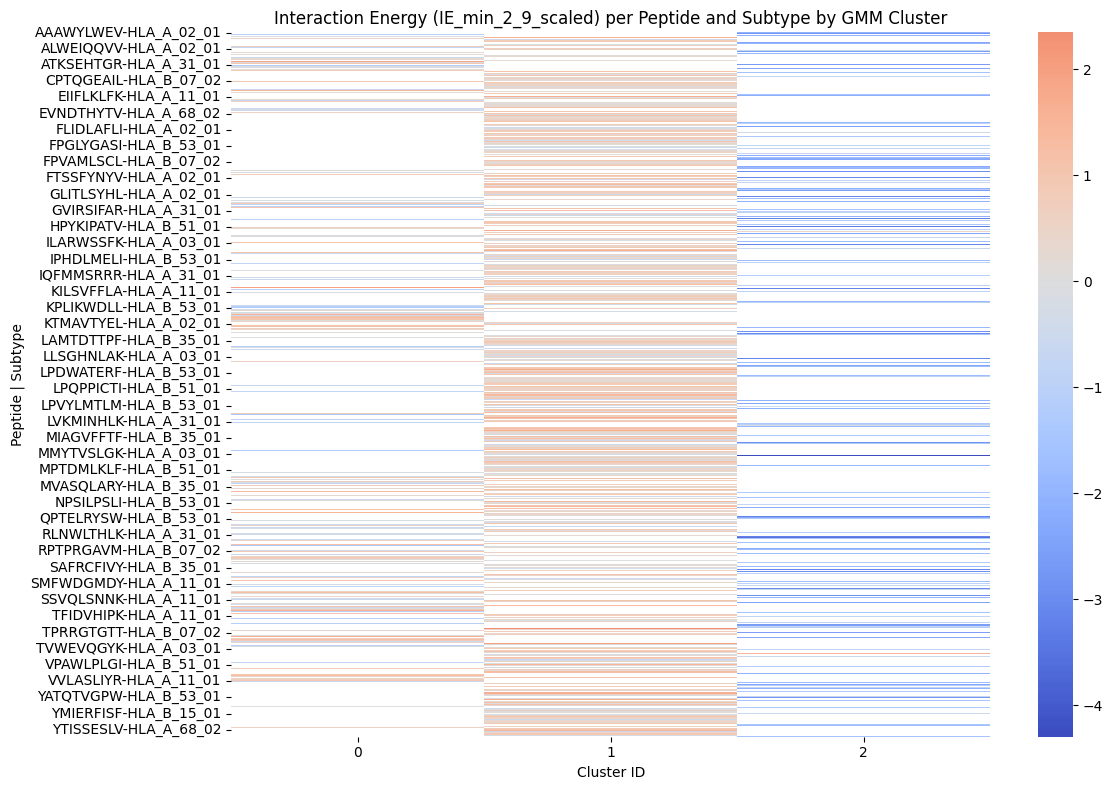

In [84]:

features = ['IE_min_2_9_scaled', 'DOPE']
df_filtered = df_merged.copy()
X = df_filtered[features].copy()


from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42)
df_filtered['gmm_cluster'] = gmm.fit_predict(X)



def get_top_models(df, cluster_col='gmm_cluster', score_cols=['DOPE', 'IE_min_2_9_scaled'], top_n=5):
    top_models = []
    for cl in df[cluster_col].unique():
        cluster_df = df[df[cluster_col] == cl].copy()
        cluster_df['rank_score'] = cluster_df[score_cols].sum(axis=1)
        cluster_df_sorted = cluster_df.sort_values(by='rank_score')
        top_models.append(cluster_df_sorted.head(top_n))
    return pd.concat(top_models)

best_models = get_top_models(df_filtered)


best_models.to_csv("best_models_gmm.csv", index=False)





heatmap_data = df_filtered.pivot_table(
    index=['peptide', 'subtype'],
    values='IE_min_2_9_scaled',
    columns='gmm_cluster',
    aggfunc='mean'
)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", center=0)
plt.title("Interaction Energy (IE_min_2_9_scaled) per Peptide and Subtype by GMM Cluster")
plt.ylabel("Peptide | Subtype")
plt.xlabel("Cluster ID")
plt.tight_layout()
plt.savefig("cluster_heatmap_gmm.png", dpi=300)
plt.show()

